<a href="https://colab.research.google.com/github/lauramsromano/categorization_vendas/blob/colab/Aplica%C3%A7%C3%A3o_Regress%C3%A3o_Logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Feito por: Laura Maria de Souza Romano

📧 e-mail - laura.sromano@hotmail.com
🔗
[linkedin](https://www.linkedin.com/in/laura-maria-de-souza-romano/)

Com base no histórico de vendas que contém informações sobre vendas realizadas e canceladas, o objetivo é desenvolver um modelo de regressão logística para prever possíveis cancelamentos.

A regressão logística é uma técnica de modelagem estatística usada para prever uma variável categórica binária, como a ocorrência ou não de cancelamentos. Nesse caso, a variável dependente será binária, indicando se uma venda foi cancelada (1) ou não (0), e as variáveis independentes podem incluir dados sobre o cliente, produto, contexto da venda, entre outros fatores relevantes.

O modelo de regressão logística calculará as probabilidades de uma venda ser cancelada com base nas variáveis independentes e atribuirá uma classificação binária (0 ou 1) com base nessa probabilidade. Ao utilizar os dados históricos para treinar o modelo, ele aprenderá a encontrar padrões e relacionamentos entre as variáveis que possam influenciar a ocorrência de cancelamentos.

Assim, após o treinamento do modelo, será possível fazer previsões sobre a probabilidade de uma venda ser cancelada com base nas informações disponíveis, permitindo que a empresa tome medidas preventivas ou proativas para evitar ou lidar adequadamente com possíveis cancelamentos.

É fundamental garantir a qualidade dos dados de treinamento e a seleção adequada das variáveis independentes para obter um modelo de regressão logística eficaz. Além disso, a avaliação do desempenho do modelo usando métricas como a precisão, a sensibilidade (recall) e a especificidade é essencial para verificar sua acurácia e realizar ajustes, se necessário, para aprimorar suas previsões.

---



> Base - https://archive.ics.uci.edu/dataset/352/online+retail

#### Bibliotecas:

In [86]:
# bibliotecas padrões:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import random

# modelos de categorização e métricas:
from sklearn.linear_model import LogisticRegression # regressão logistica
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC #SVM
from sklearn.model_selection import train_test_split # separação treino e teste

from sklearn.metrics import roc_auc_score #
from sklearn.metrics import accuracy_score # cálculo da acurácia

# pipeline:
from sklearn.pipeline import Pipeline # gerando pipeline
from sklearn.pipeline import make_pipeline # extraindo infos da pipeline
from sklearn.compose import ColumnTransformer # agrupação de métodos para pipeline

# processamento de variáveis numéricas:
from sklearn.preprocessing import RobustScaler # ajuste da escala das features

# processamento de variáveis nominais:
!pip install category_encoders
from category_encoders import CountEncoder # transformação por frequência
from sklearn.impute import SimpleImputer #

# processamento target:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

# validação cruzada:
from sklearn.model_selection import (cross_validate, StratifiedKFold) # validação cruzada

# tratamento data e hora
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [87]:
# leitura da base original
amostra = pd.read_excel('online_retail.xlsx')

#### ***Análises iniciais da amostra original:***


---



Resumo das análises:

- Levantamento geral dos dados para tomada de decisão nas etapas de tratamento.
  - Verificando divergências nas informações;  
  - Levantamento percentual das informações verificadas;
  - Verificando valores nulos;
  - Outras informações presentes na amostra (períodos de tempo, paises presentes na base, etc.)

***Glossário de features já existentes na base:***
- `InvoiceNo`: Número da fatura: número integral de 6 dígitos atribuído exclusivamente a cada transação.
Se este código começar com a letra 'c', indica um cancelamento.

  - Exemplo: C581490 - Cancelado, 581256 - Não Cancelado, A581490, 256, etc.	- Código de transação inválido

- `StockCode`: Código do produto: um número integral de 5 dígitos atribuído exclusivamente a cada produto distinto.

  - Exemplo: 35004 - Código de produto válido, 35004C, M, etc. - Código de produto inválido.

- `Description`: Nome do produto.
-` Quantity`: As quantidades de cada produto (item) por transação.
- `InvoiceDate`: Dia e a hora em que cada transação foi gerada.
- `UnitPrice`: Preço do produto por unidade em libras esterlinas.
- `CustomerID`: Número integral de 5 dígitos atribuído exclusivamente a cada cliente.

  - Exemplo: 14527 - Código de cliente válido, F14527, 855, etc. - Código de cliente inválido.

- `Country`: Nome do país onde cada cliente reside.

***Features adicionadas durante o tratamento:***

- `TotalPrice`: Valor total de cada transação, resultado da multiplicação entre as colunas `'UnitPrice'` e `'Quantity'`.
- `Status`: Informação se a transação foi cancelada (Cancelado) ou não (Não Cancelado).

In [88]:
# Amostra de dados:
amostra.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [89]:
# infos gerais:
amostra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [90]:
amostra.shape

(541909, 8)

In [91]:
# informações estatísticas:
amostra.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


- Foi observado que as colunas `'Quantity' `e `'UnitPrice'` apresentaram **valores negativos**, porém, esses valores correspondem a compras canceladas e não serão tratados ou removidos da base de dados.

- Além disso, identificamos que tanto a coluna `'Quantity'` quanto a coluna `'UnitPrice'` apresentam um **desvio padrão elevado**, o que pode impactar negativamente o desempenho do modelo. Para lidar com essa situação iremos explorar alternativas que visam melhorar a distribuição dos dados.

In [92]:
# vendas canceladas:
amostra['InvoiceNo'] = amostra['InvoiceNo'].astype(str)
amostra[amostra['InvoiceNo'].str.contains('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [93]:
# qtd. de vendas canceladas:
len(amostra[amostra['InvoiceNo'].str.contains('C')])

9288

In [94]:
# verificando se há valores negativos em 'Quantity' ou em 'UnitPrice' que não sejam referentes a vendas canceladas:
amostra[(~amostra['InvoiceNo'].str.startswith('C')) & ((amostra['Quantity'] <= 0) | (amostra['UnitPrice'] <= 0))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,NaN,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,NaN,United Kingdom
538554,581408,85175,NaN,20,2011-12-08 14:06:00,0.0,NaN,United Kingdom


In [95]:
# percentual de vendas 'não canceladas' com qtd ou valor unitário negativos:
round(len(amostra[(~amostra['InvoiceNo'].str.startswith('C')) & ((amostra['Quantity'] <= 0) | (amostra['UnitPrice'] <= 0))])/ len(amostra)*100, 2)

0.46

In [96]:
# percentual de vendas canceladas:
round(len(amostra[amostra['InvoiceNo'].str.contains('C')]) / len(amostra)*100, 2)

1.71

- Aproximadamente **0.5%** dos valores na base apresentam informações zeradas ou negativas em `'Quantity'` e `'UnitPrice'`, porém, não estão relacionados a vendas canceladas. Para garantir a consistência dos dados, iremos proceder com a remoção dessas informações na base.

- O percentual de vendas canceladas na amostra é de aproximadamente **2%** dos dados, indicando um desequilíbrio nos dados. Para abordar essa questão, iremos verificar e aplicar técnicas para realizar o balancear os dados.

In [97]:
# verificando valores ausentes:
(amostra.isna().sum() / len(amostra)*100).sort_values(ascending=False)

CustomerID     24.926694
Description     0.268311
InvoiceNo       0.000000
StockCode       0.000000
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
Country         0.000000
dtype: float64

In [98]:
# verificando se há valores diferentes do padrão para 'InvoiceNo' (valores devem ter 6 ou 7 digitos [para casos cancelado])
codigos_unicos_invoice = amostra['InvoiceNo'].astype(str).tolist()
codigos_invalidos = [codigo for codigo in codigos_unicos_invoice if len(str(codigo)) < 6 or len(str(codigo)) > 7]
f'Há {len(codigos_invalidos)} código(s) divergente(s). Alguns exemplos: {codigos_invalidos}'

'Há 0 código(s) divergente(s). Alguns exemplos: []'

In [99]:
# verificando se há valores diferentes do padrão para 'InvoiceNo' (valores devem ter 5 dígitos)
codigos_unicos_stock = amostra['StockCode'].tolist()
codigos_invalidos = [codigo for codigo in codigos_unicos_stock if len(str(codigo)) != 5 or not str(codigo).isdigit()]
f'Há {len(codigos_invalidos)} código(s) divergente(s). Alguns exemplos: {codigos_invalidos[:5]}'

"Há 54873 código(s) divergente(s). Alguns exemplos: ['85123A', '84406B', '84029G', '84029E', 'POST']"

In [100]:
round(len(codigos_invalidos) / len(amostra)*100,2)

10.13

In [101]:
# alterando o tipo da variável 'CustomerID' para string e removendo o '.0' no final:
amostra['CustomerID'] = amostra['CustomerID'].astype(str).str.split('.').str[0]

In [102]:
# verificando se há valores diferentes do padrão para 'CustomerID'
codigos_unicos_customer = amostra['CustomerID'].tolist()
codigos_invalidos = [codigo for codigo in codigos_unicos_customer if len(str(codigo)) != 5 or not str(codigo).isdigit()]
f'Há {len(codigos_invalidos)} código(s) divergente(s). Alguns exemplos: {codigos_invalidos[:5]}'

"Há 135080 código(s) divergente(s). Alguns exemplos: ['nan', 'nan', 'nan', 'nan', 'nan']"

In [103]:
round(len(codigos_invalidos) / len(amostra)*100,2)

24.93

- A coluna `'CustomerID'` apresenta valores nulos, representando aproximadamente **25%** dos registros. Essa coluna é importante para o poder de predição do modelo, portanto será necessário encontrar uma estratégia adequada para lidar com esses valores ausentes.

- A coluna `'InvoiceNo'` não apresenta valores despadronizados, ou seja, não há problemas a serem tratados nessa coluna.

- A coluna `'StockCode'` possui valores despadronizados, afetando cerca de **10%** dos registros. Será necessário realizar algum tipo de tratamento para lidar com esses valores inconsistentes.

- Os valores despadronizados em `'CustomerID'` são registros em 'nan', representando **24%** dos dados. Como pontuado, essa coluna é importante para o poder de predição do modelo, portanto será necessário encontrar uma estratégia adequada para lidar com esses valores divergentes.

In [104]:
# Verificando proporção de infos por pais:
amostra['Country'].value_counts() / len(amostra)*100

United Kingdom          91.431956
Germany                  1.752139
France                   1.579047
EIRE                     1.512431
Spain                    0.467422
Netherlands              0.437527
Belgium                  0.381798
Switzerland              0.369435
Portugal                 0.280305
Australia                0.232327
Norway                   0.200403
Italy                    0.148180
Channel Islands          0.139876
Finland                  0.128250
Cyprus                   0.114779
Sweden                   0.085254
Unspecified              0.082302
Austria                  0.073998
Denmark                  0.071783
Japan                    0.066063
Poland                   0.062926
Israel                   0.054806
USA                      0.053699
Hong Kong                0.053145
Singapore                0.042258
Iceland                  0.033585
Canada                   0.027864
Greece                   0.026942
Malta                    0.023436
United Arab Em

In [105]:
# Qtd de paises:
amostra['Country'].nunique()

38

- 91% dos dados são referentes a compras realizadas no **Reino Unido (United Kingdom**), o que indica uma concentração significativa de registros nesse país. Ou seja, as informação pode ser relevante para **análises específicas relacionadas ao mercado britânico.**

In [106]:
# Anos presente na base:
amostra['InvoiceDate'].dt.year.unique()

array([2010, 2011])

In [107]:
# Qtd de itens:
amostra['StockCode'].nunique()

4070

In [108]:
# Qtd de clientes:
amostra['CustomerID'].dropna().nunique()

4373

**Resumo das conclusões:**

A amostra contém dados de vendas referentes aos anos de 2010 e 2011. Esses dados incluem um total de 4.070 itens diferentes vendidos para um conjunto de 4.373 clientes em 38 países, sendo United Kingdom (Reino Unido) o pais mais representativo, com uma parcela de 91% da amostra.

> Colunas `'Quantity'` e `'UnitPrice'`:

Os valores negativos encontrados nessas colunas são referentes a vendas canceladas. Para evitar qualquer influência indesejada na base de dados, as vendas não canceladas com informações negativas ou zeradas nessas colunas serão removidas.

Além disso, é importante destacar que as colunas `'Quantity'` e `'UnitPrice'` apresentam um desvio padrão elevado, o que pode prejudicar o desempenho do modelo. A fim de melhorar a distribuição dos dados, serão exploradas alternativas para tratar essa situação.

> Coluna `'InvoiceNo'`:

Observamos que a base de dados está desbalanceada, com apenas 2% dos registros relacionados a cancelamentos. Para ajustar esse desequilíbrio, será necessário aplicar técnicas apropriadas de tratamento, visando obter uma distribuição mais equitativa e representativa dos dados.

> Colunas `'CustomerID'` e '`StockCode'`:

Ambas as colunas apresentam valores despadronizados que precisarão ser tratados.

#### ***Preparação e análise da base:***

---



Resumo dos passos:

- Gerando a base que será utilizada e fazendo os ajustes necessários:
  - Tratamento de informações divergentes;
  - Tratamento de nulos;
  - Filtros.
- Tratamento, criação e análise das features.
- Definição, criação, tratamento e análise da target.
- EDA das informações finais da base.

In [109]:
# Criando base para tratamento e aplicação do modelo, matendo a 'amostra' sem alterações:
base_amostra = pd.DataFrame()
base_amostra = amostra.copy()
base_amostra

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [110]:
# Removendo informações incorretas da base:
base_amostra.drop(base_amostra[(~base_amostra['InvoiceNo'].str.startswith('C'))
& ((base_amostra['Quantity'] <= 0)
| (base_amostra['UnitPrice'] <= 0))].index, inplace=True)

##### ***Features:***

Tratamento de nulos e divergências:
- Colunas `'CustomerID`' e `'StockCode`'
---


In [111]:
# verificando valores ausentes:
(amostra.isna().sum() / len(amostra)*100).sort_values(ascending=False)

Description    0.268311
InvoiceNo      0.000000
StockCode      0.000000
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.000000
Country        0.000000
dtype: float64

- Após a remoção dos valores divergentes da base de dados, observamos uma redução significativa no percentual de dados nulos, com apenas `'Description'` apresentando **0.2%** de valores nulos. Com base nessa informação, podemos concluir que não é necessário realizar um tratamento adicional para lidar com valores nulos nesse momento, nos permitindo prosseguir com as análises e modelagem sem maiores intervenções nesse aspecto.

In [112]:
# Percentual de valores 'nan' na coluna 'CustomerID' em relação a base:
round(len(base_amostra[base_amostra['CustomerID'] == 'nan'])/ len(base_amostra)*100, 2)

24.58

In [113]:
# Removendo os valores da base:
base_amostra = base_amostra[base_amostra['CustomerID'] != 'nan']

- Representando **24%** dos dados, removemos as informações 'nan' da coluna `'CustomerID'`.

In [114]:
# verificando se há valores diferentes do padrão para 'InvoiceNo' (valores devem ter 5 dígitos)
codigos_unicos_stock = base_amostra['StockCode'].tolist()
codigos_invalidos = [codigo for codigo in codigos_unicos_stock if len(str(codigo)) != 5 or not str(codigo).isdigit()]
f'Há {len(codigos_invalidos)} código(s) divergente(s). Alguns exemplos: {codigos_invalidos[:5]}'

"Há 35801 código(s) divergente(s). Alguns exemplos: ['85123A', '84406B', '84029G', '84029E', 'POST']"

In [115]:
round(len(codigos_invalidos) / len(amostra)*100,2)

6.61

In [116]:
# Remover os valores invalidos da coluna 'StockCode':
base_amostra = base_amostra[~base_amostra['StockCode'].isin(codigos_invalidos)]

- Representando agora aproximandamente **7%** dos dados, removemos os valores divergentes da coluna `'StockCode'`.

Filtro de data para recorte da base:
- A base final será referente aos período de Outubro a Dezembro de 2011.


---



In [117]:
# Definir a data limite como dezembro de 2011:
data_limite = pd.to_datetime('2011-12-01')

# Filtrar os registros dos últimos 3 meses:
base_amostra = base_amostra[base_amostra['InvoiceDate'] >= data_limite - pd.DateOffset(months=2)]

# Exibir os registros filtrados:
base_amostra['InvoiceDate'].dt.month.unique()

array([10, 11, 12])

In [118]:
base_amostra['InvoiceDate'].dt.year.unique()

array([2011])

In [119]:
# Proporção da base final em relação a base original
round(len(base_amostra) / len(amostra)*100, 2)

22.92

Criando feature `'TotalPrice'`:


---



In [120]:
# Criando coluna com o cálculo do preço total da transação: 'TotalPrice':
base_amostra['TotalPrice'] = base_amostra['Quantity'] * base_amostra['UnitPrice']
base_amostra[['Quantity', 'UnitPrice', 'TotalPrice']]

,Quantity,UnitPrice,TotalPrice
370931,48,4.95,237.60
370932,20,1.25,25.00
370933,4,0.85,3.40
370934,15,7.08,106.20
370935,4,4.95,19.80
...,...,...,...
541904,12,0.85,10.20
541905,6,2.10,12.60
541906,4,4.15,16.60
541907,4,4.15,16.60


Verificandos e tratando informações estatísticas sobre as variáveis `'TotalPrice'`, `'UnitPrice'` e `'Quantity'`:

---



In [121]:
base_amostra[['TotalPrice', 'UnitPrice', 'Quantity']].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalPrice,124193.0,18.167294,679.044724,-168469.60,3.40,9.95,17.70,168469.6
UnitPrice,124193.0,2.763063,3.129232,0.04,1.25,1.79,3.75,165.0
Quantity,124193.0,10.716425,327.375629,-80995.00,2.00,4.00,12.00,80995.0


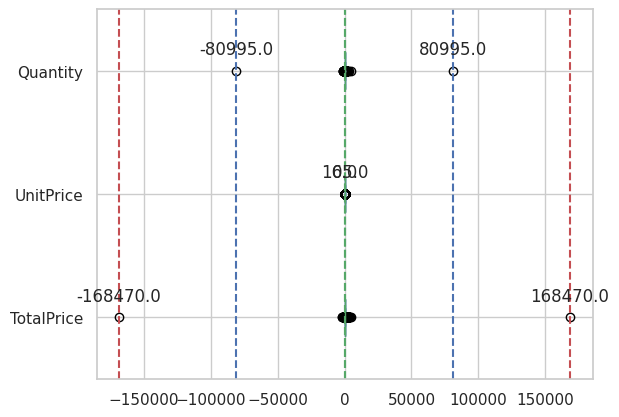

In [122]:
colors = ['r', 'g', 'b']
base_amostra[['TotalPrice', 'UnitPrice', 'Quantity']].plot(kind='box', vert=False)

outliers = base_amostra[['TotalPrice', 'UnitPrice', 'Quantity']].describe().loc[['min', 'max']].values.round()

for i, limit in enumerate(outliers.T):
    color = colors[i % len(colors)]

    plt.axvline(x=limit[0], color=color, linestyle='--')
    plt.axvline(x=limit[1], color=color, linestyle='--')

    for j, value in enumerate(limit):
        plt.text(value, i+1.1, f'{value}', ha='center', va='bottom')

plt.show()

In [123]:
outliers_df = pd.DataFrame(outliers, columns=['TotalPrice', 'UnitPrice', 'Quantity'], index=['min', 'max'])
outliers_df

,TotalPrice,UnitPrice,Quantity
min,-168470.0,0.0,-80995.0
max,168470.0,165.0,80995.0


As colunas `'TotalPrice'` e `'Quantity'` exibem valores discrepantes, resultando em um **alto desvio padrão** de 679 e 327, respectivamente. A fim de melhor equilibrar a distribuição dos dados, será aplicada a estratégia de remover esses valores discrepantes, também conhecidos como outliers, em ambas as colunas.

In [124]:
# Removendo valores max e mim de 'TotalPrice' e 'Quantity':
base_amostra = base_amostra[(base_amostra['TotalPrice'] != base_amostra['TotalPrice'].max()) & (base_amostra['Quantity'] != base_amostra['Quantity'].min())]

In [125]:
base_amostra[['TotalPrice', 'UnitPrice', 'Quantity']].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalPrice,124191.0,18.167586,63.523387,-1836.00,3.40,9.95,17.70,4992.0
UnitPrice,124191.0,2.763074,3.129256,0.04,1.25,1.79,3.75,165.0
Quantity,124191.0,10.716598,39.101019,-1296.00,2.00,4.00,12.00,4800.0


- Observamos uma diminuição significativa nos desvios padrão de `'TotalPrice'` e `'Quantity'`, para 63 e 39, respectivamente. Embora ainda sejam valores relativamente elevados, percebe-se uma redução substancial em relação aos números anteriores.

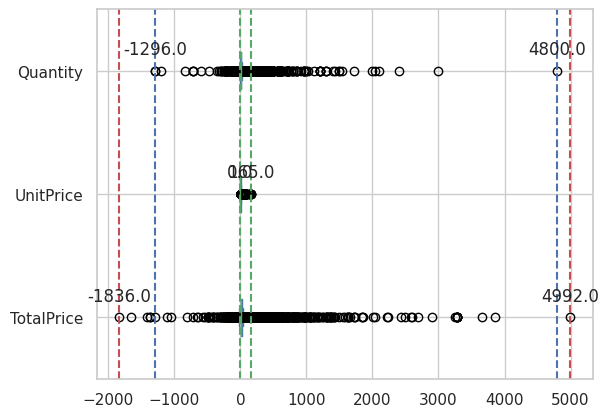

In [126]:
colors = ['r', 'g', 'b']
base_amostra[['TotalPrice', 'UnitPrice', 'Quantity']].plot(kind='box', vert=False)

outliers = base_amostra[['TotalPrice', 'UnitPrice', 'Quantity']].describe().loc[['min', 'max']].values.round()

for i, limit in enumerate(outliers.T):
    color = colors[i % len(colors)]

    plt.axvline(x=limit[0], color=color, linestyle='--')
    plt.axvline(x=limit[1], color=color, linestyle='--')

    for j, value in enumerate(limit):
        plt.text(value, i+1.1, f'{value}', ha='center', va='bottom')

plt.show()

##### ***Target:***

Tratamento, criação e análise da target:

---



In [127]:
# Valores únicos em 'InvoiceNo':
base_amostra['InvoiceNo'] = base_amostra['InvoiceNo'].astype(str)
base_amostra[base_amostra['InvoiceNo'].str.contains('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
372165,C569233,22350,ILLUSTRATED CAT BOWL,-1,2011-10-02 15:26:00,2.55,17841,United Kingdom,-2.55
372166,C569233,22467,GUMBALL COAT RACK,-2,2011-10-02 15:26:00,2.55,17841,United Kingdom,-5.10
372881,C569251,85066,CREAM SWEETHEART MINI CHEST,-1,2011-10-03 10:37:00,12.75,12957,United Kingdom,-12.75
373247,C569318,22628,PICNIC BOXES SET OF 3 RETROSPOT,-1,2011-10-03 12:14:00,4.95,13505,Switzerland,-4.95
373248,C569318,22328,ROUND SNACK BOXES SET OF 4 FRUITS,-3,2011-10-03 12:14:00,2.95,13505,Switzerland,-8.85
...,...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397,United Kingdom,-23.40
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,-9.13
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,-1.25


In [128]:
# Criando coluna 'Status' para pontuar os cancelamentos:
base_amostra['Status'] = base_amostra['InvoiceNo'].apply(lambda x: 'Cancelado' if str(x).startswith('C') else 'Não Cancelado')
base_amostra[['Status', 'InvoiceNo']]

,Status,InvoiceNo
370931,Não Cancelado,569203
370932,Não Cancelado,569203
370933,Não Cancelado,569204
370934,Não Cancelado,569204
370935,Não Cancelado,569204
...,...,...
541904,Não Cancelado,581587
541905,Não Cancelado,581587
541906,Não Cancelado,581587
541907,Não Cancelado,581587


<Axes: >

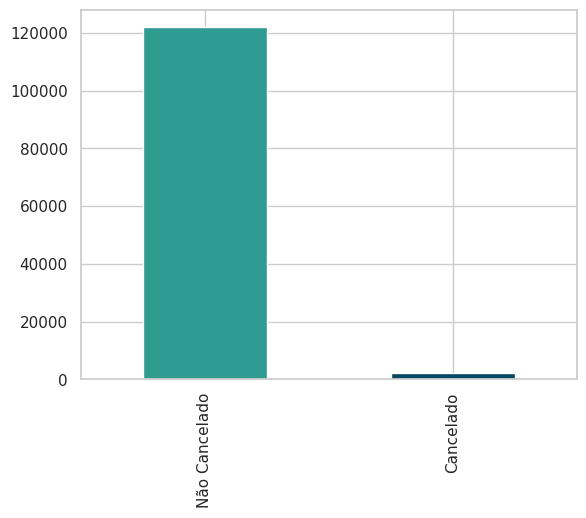

In [129]:
# Proporção da target na base:
colors = ['#309b91', '#054863']
base_amostra['Status'].value_counts().plot(kind = 'bar', color=colors)

In [130]:
round(base_amostra['Status'].value_counts() / len(base_amostra)*100, 2)

Não Cancelado    98.17
Cancelado         1.83
Name: Status, dtype: float64

- Verificamos que o percentual de compras canceladas é bastante baixo, representando menos de **2%** do total de registros. Para lidar com esse desequilíbrio nos dados, adotaremos no momento da modelagem a técnica de ***Under-sampling.*** Essa abordagem envolve extrair um subconjunto aleatório da classe majoritária, preservando as características da classe minoritária, sendo ideal para situações onde você tem grandes volumes de dados.

- O objetivo é **aumentar a representatividade da classe minoritária na base de dados, proporcionando um melhor desempenho do modelo e evitando possíveis viés decorrentes do desequilíbrio entre as classes.** Dessa forma, garantimos que o modelo seja capaz de capturar adequadamente os padrões e características da classe cancelada, contribuindo para uma melhor tomada de decisão.

##### **EDA** sobre as informações base:

Resumo das análises:

- Análise Regional (pais e continente).
- Análise dos itens e suas possíveis categorias.
- Análise temporal (vendas e cancelamentos em intervalos de hora).

---



In [131]:
# Compras por pais:
base_amostra['Country'].value_counts() / len(amostra)*100

United Kingdom     20.633538
France              0.470928
Germany             0.468344
EIRE                0.384935
Spain               0.118470
Portugal            0.111642
Belgium             0.103338
Netherlands         0.102969
Switzerland         0.088945
Italy               0.062741
Norway              0.062372
Cyprus              0.046871
USA                 0.046318
Channel Islands     0.031740
Finland             0.030079
Australia           0.027495
Austria             0.022144
Sweden              0.021590
Denmark             0.018453
Poland              0.012917
Japan               0.010334
RSA                 0.009965
Iceland             0.009965
Greece              0.006459
Israel              0.005167
Singapore           0.004982
Malta               0.002768
Czech Republic      0.001845
Name: Country, dtype: float64

In [132]:
# Média do 'TotalPrice' por pais:
base_amostra.groupby('Country')['TotalPrice'].mean().sort_values(ascending = False)

Country
Japan              183.771250
Australia          158.874832
Netherlands        135.362778
Sweden              67.646410
Singapore           34.301481
Norway              31.973521
Denmark             31.515200
Switzerland         27.300996
EIRE                25.829727
Iceland             24.895185
Channel Islands     22.429302
Germany             21.874275
France              21.632610
Czech Republic      21.573000
Belgium             20.683107
Finland             19.638160
Italy               19.310382
Poland              18.348143
Austria             18.190500
RSA                 17.584444
United Kingdom      16.902602
Cyprus              16.711142
Greece              15.599714
Portugal            15.486727
Spain               14.598723
Malta               12.720667
USA                  4.837331
Israel               3.802500
Name: TotalPrice, dtype: float64

In [133]:
# Criando coluna de 'Continente':
dict_continent = {
    'United Kingdom': 'Europa',
    'Switzerland': 'Europa',
    'France': 'Europa',
    'Spain': 'Europa',
    'Germany': 'Europa',
    'Belgium': 'Europa',
    'Israel': 'Ásia',
    'Channel Islands': 'Europa',
    'Australia': 'Oceania',
    'Netherlands': 'Europa',
    'EIRE': 'Europa',
    'Portugal': 'Europa',
    'Italy': 'Europa',
    'Denmark': 'Europa',
    'Cyprus': 'Europa',
    'Czech Republic': 'Europa',
    'USA': 'América do Norte',
    'Norway': 'Europa',
    'Finland': 'Europa',
    'RSA': 'África',
    'Singapore': 'Ásia',
    'Sweden': 'Europa',
    'Austria': 'Europa',
    'Japan': 'Ásia',
    'Iceland': 'Europa',
    'Poland': 'Europa',
    'Malta': 'Europa',
    'Greece': 'Europa'
}

base_amostra['Continent'] = base_amostra['Country'].map(dict_continent)

In [134]:
# Média de 'UnitPrice' por continente:
base_amostra.groupby('Continent')['UnitPrice'].mean().sort_values(ascending = False)

Continent
África              4.418889
Ásia                3.343514
Oceania             3.012416
Europa              2.762968
América do Norte    2.054502
Name: UnitPrice, dtype: float64

In [135]:
# Média de 'UnitPrice' por continente:
base_amostra.groupby('Continent')['TotalPrice'].mean().sort_values(ascending = False)

Continent
Oceania             158.874832
Ásia                102.016216
Europa               17.950034
África               17.584444
América do Norte      4.837331
Name: TotalPrice, dtype: float64

In [136]:
# Média de 'Country' por continente:
base_amostra.groupby('Country')['UnitPrice'].mean().sort_values(ascending = False)

Country
Singapore          5.642222
Cyprus             5.013622
Malta              4.688667
RSA                4.418889
Italy              4.025735
Finland            3.590798
Channel Islands    3.437791
Greece             3.381714
EIRE               3.299056
Belgium            3.284161
Norway             3.264556
Spain              3.192757
Australia          3.012416
Austria            2.852667
Germany            2.793775
United Kingdom     2.740471
Japan              2.709464
Portugal           2.701983
Poland             2.698143
Switzerland        2.676286
France             2.675513
Netherlands        2.410287
Israel             2.395000
Iceland            2.283333
USA                2.054502
Sweden             1.936239
Denmark            1.873700
Czech Republic     1.083000
Name: UnitPrice, dtype: float64

- Conforme mencionado anteriormente, a maioria das compras foi realizada no Reino Unido (Unit Kingdom), porém o país ocupa a 21ª posição em termos de média total de compras. Por outro lado, o Japão possui a maior média total de compras, apesar de não representar nem 1% das vendas totais.

- No que diz respeito aos continentes, constata-se que o continente africano apresenta os itens mais caros, em média, enquanto ocupa a segunda posição em relação ao menor valor total de compras. Já a Oceania é o continente onde as pessoas gastaram mais em média.

In [137]:
# Qtd de itens vendidos:
base_amostra.groupby(['StockCode', 'Description'])['StockCode'].count().sort_values(ascending=False).head(10)

StockCode  Description                       
22086      PAPER CHAIN KIT 50'S CHRISTMAS        673
23084      RABBIT NIGHT LIGHT                    655
23355      HOT WATER BOTTLE KEEP CALM            538
22910      PAPER CHAIN KIT VINTAGE CHRISTMAS     465
23344      JUMBO BAG 50'S CHRISTMAS              435
22197      POPCORN HOLDER                        408
22865      HAND WARMER OWL DESIGN                406
22423      REGENCY CAKESTAND 3 TIER              399
84879      ASSORTED COLOUR BIRD ORNAMENT         398
22578      WOODEN STAR CHRISTMAS SCANDINAVIAN    380
Name: StockCode, dtype: int64

- Na base de dados, não há uma segmentação de itens por categoria. Ao analisar os 10 itens mais vendidos, observamos, por exemplo, que eles consistem em itens de decoração e utensílios gerais. Dentro da categoria de decoração, identificamos 3 itens com tema natalino, o que faz sentido, uma vez que estamos verificando os últimos 3 meses do ano.

- No entanto, essa análise superficial pode não ser precisa o suficiente para compreender completamente as informações. Uma alternativa viável seria utilizar um modelo de clusterização, como o KNN ou um SVM, para segmentar de forma mais precisa e obter uma compreensão mais detalhada das categorias presentes. No entanto, essa abordagem requereria uma categorização manual inicial, a fim de obter dados reais para treinar e testar o modelo. Considerando que já possuímos a descrição do item e que a coluna de categorias não alteraria significativamente a capacidade de predição do modelo, optamos por não realizar essa etapa.

Tratamento de data e hora:


---



In [138]:
# Criando coluna com intervalos de horas:
base_amostra['InvoiceHour'] = base_amostra['InvoiceDate'].dt.strftime('%H:%M:%S')
intervalos = pd.interval_range(start=pd.to_timedelta('00:00:00'), end=pd.to_timedelta('23:00:00'), freq='1H')

base_amostra['InvoiceHour_Intervalo'] = pd.cut(pd.to_timedelta(base_amostra['InvoiceHour']), bins=intervalos, labels=intervalos[:-1])

base_amostra['InvoiceHour'] = base_amostra['InvoiceHour_Intervalo'].apply(lambda x: datetime.strftime(datetime(1900, 1, 1) + x.left, '%H'f'h'))

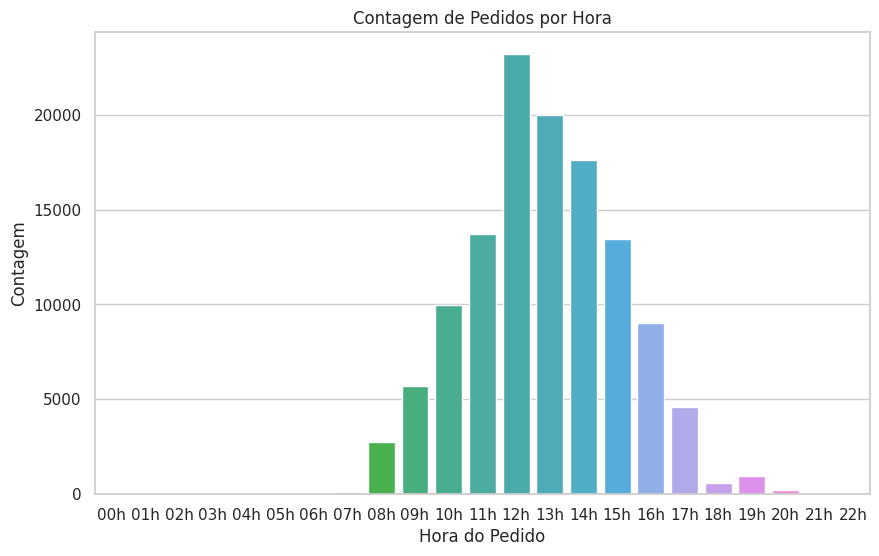

In [139]:
# Vendas 'não canceladas' por horário:
invoice_hour_counts_not = base_amostra[~base_amostra['InvoiceNo'].str.startswith('C')].groupby('InvoiceHour')['InvoiceNo'].count()

plt.figure(figsize=(10, 6))
sns.barplot(x=invoice_hour_counts_not.index, y=invoice_hour_counts_not.values)
plt.xlabel('Hora do Pedido')
plt.ylabel('Contagem')
plt.title('Contagem de Pedidos por Hora')
plt.show()

In [140]:
# itens não cancelados no período das 12h
base_amostra[(~base_amostra['InvoiceNo'].str.startswith('C')) & (base_amostra['InvoiceHour'] == '12h')].groupby('Description')['Description'].count().sort_values(ascending=False).head(10)

Description
PAPER CHAIN KIT 50'S CHRISTMAS        126
HOT WATER BOTTLE KEEP CALM            111
RABBIT NIGHT LIGHT                    106
JUMBO BAG 50'S CHRISTMAS               94
REX CASH+CARRY JUMBO SHOPPER           93
PAPER CHAIN KIT VINTAGE CHRISTMAS      83
GARDENERS KNEELING PAD KEEP CALM       81
POPCORN HOLDER                         78
HAND WARMER OWL DESIGN                 77
WOODEN STAR CHRISTMAS SCANDINAVIAN     76
Name: Description, dtype: int64

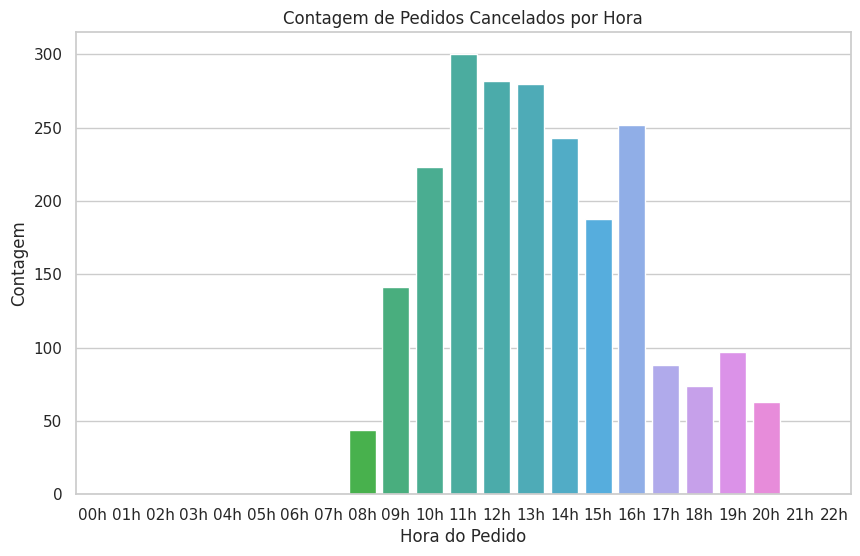

In [141]:
# Vendas canceladas por horário:
invoice_hour_counts = base_amostra[base_amostra['InvoiceNo'].str.startswith('C')].groupby('InvoiceHour')['InvoiceNo'].count()

plt.figure(figsize=(10, 6))
sns.barplot(x=invoice_hour_counts.index, y=invoice_hour_counts.values)
plt.xlabel('Hora do Pedido')
plt.ylabel('Contagem')
plt.title('Contagem de Pedidos Cancelados por Hora')
plt.show()

- A maioria das vendas ocorre entre as 11h da manhã e as 14h, com pico ao 12h indicando um período de maior atividade comercial.

- Além disso, observa-se que os cancelamentos também apresentam um volume significativo durante esse mesmo período, com pico as 11h, indicando uma possível relação entre as horas de maior volume de vendas e os cancelamentos. Outro pico de cancelamentos ocorre às 16h da tarde.

In [142]:
# itens cancelados no período das 11h
base_amostra[(base_amostra['InvoiceNo'].str.startswith('C')) & (base_amostra['InvoiceHour'] == '11h')].groupby('Description')['Description'].count().sort_values(ascending=False).head(10)

Description
CHILDRENS APRON SPACEBOY DESIGN        3
FELTCRAFT CUSHION OWL                  3
LUNCH BAG CARS BLUE                    3
JUMBO BAG 50'S CHRISTMAS               3
JUMBO STORAGE BAG SUKI                 3
JUMBO BAG PINK POLKADOT                3
POPCORN HOLDER                         3
SPACEBOY LUNCH BOX                     2
SET OF 60 I LOVE LONDON CAKE CASES     2
SET OF 4 KNICK KNACK TINS LONDON       2
Name: Description, dtype: int64

In [143]:
# itens cancelados no período das 16h
base_amostra[(base_amostra['InvoiceNo'].str.startswith('C')) & (base_amostra['InvoiceHour'] == '16h')].groupby('Description')['Description'].count().sort_values(ascending=False).head(10)

Description
PARISIENNE JEWELLERY DRAWER            4
SET OF 3 REGENCY CAKE TINS             3
SET OF 3 CAKE TINS PANTRY DESIGN       3
CLASSIC GLASS COOKIE JAR               3
SET OF TEA COFFEE SUGAR TINS PANTRY    3
VINTAGE DOILY DELUXE SEWING KIT        3
COLOUR GLASS. STAR T-LIGHT HOLDER      3
REGENCY CAKESTAND 3 TIER               3
ROSES REGENCY TEACUP AND SAUCER        2
REGENCY MILK JUG PINK                  2
Name: Description, dtype: int64

- Durante os períodos de maior número de cancelamentos, não observamos uma concentração significativa em nenhum item específico, o que sugere que os cancelamentos ocorrem de forma aleatória.

#### ***Aplicação do Modelo:***

---



Resumos dos passos:

- Separação das features numéricas e categóricas.
- Criação da pipeline para tratamento das features.
  - Método RobustScaler - variáveis numéricas;
  - Método CountEncoder - variáveis nominais;
  - Método RandomUnderSampler - desbalanceamento da target.
- Aplicação do modelo.
- Análise de métrica de eficiência do modelo.

In [144]:
# Removendo coluna com valores de data/hora:
base_amostra = base_amostra.drop(columns=['InvoiceDate', 'InvoiceHour', 'InvoiceHour_Intervalo']).copy()

In [145]:
# Separando variáveis categóricas e numéricas:
cat_features = base_amostra.select_dtypes('object').drop(columns = 'Status').columns.to_list()
num_features = base_amostra.select_dtypes(exclude = 'object').columns.to_list()

cat_features, num_features

(['InvoiceNo',
  'StockCode',
  'Description',
  'CustomerID',
  'Country',
  'Continent'],
 ['Quantity', 'UnitPrice', 'TotalPrice'])

In [146]:
# Divisão em dados de treino e de teste:
X = base_amostra.drop(columns = ['Status'])
y = base_amostra.Status.map({'Não Cancelado': 0,'Cancelado': 1})

In [147]:
# separa em treino e teste
SEED = 546744165
X_train, X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size = 0.3,
                                                     random_state = SEED,
                                                     stratify = y) #explicar

<Axes: >

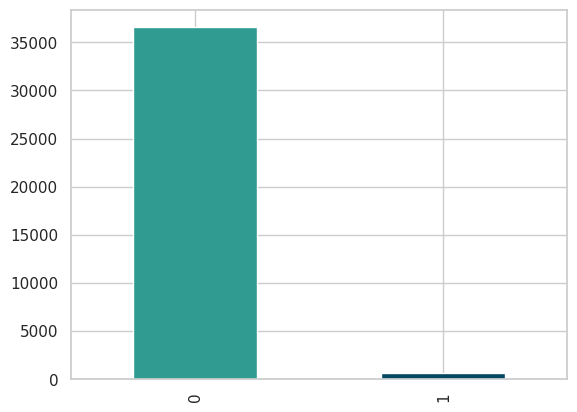

In [148]:
# Distribuição da target antes do tratamento:
pd.Series(y_test).value_counts().plot(kind = 'bar', color=colors)

In [149]:
# from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=SEED)
X_res, y_res = rus.fit_resample(X_train, y_train)
X_res_test, y_res_test = rus.fit_resample(X_test, y_test)

In [150]:
# Distribuição da target após do tratamento:
pd.Series(y_res).value_counts()

0    1592
1    1592
Name: Status, dtype: int64

<Axes: >

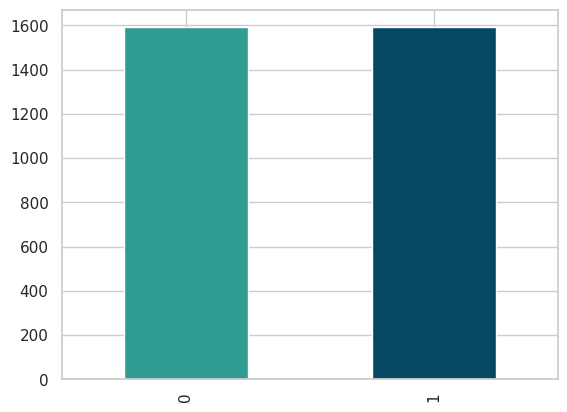

In [151]:
pd.Series(y_res).value_counts().plot(kind = 'bar', color=colors)

In [152]:
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import SMOTENC

# # smote = SMOTE()
# categorical_features = [0, 1, 2, 5, 6, 8]
# smotenc = SMOTENC(categorical_features=categorical_features)

# X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train, y_train)
# X_test_resampled, y_test_resampled = smotenc.fit_resample(X_test, y_test)

In [153]:
# Distribuição da target após do tratamento:
pd.Series(y_res).value_counts()

0    1592
1    1592
Name: Status, dtype: int64

In [154]:
# criar o transformador para aplicar as transformações:
transformer = ColumnTransformer(
     transformers=[
          ('count_encoder', CountEncoder(), cat_features),
          ('robust_scaler', RobustScaler(), num_features)],
           remainder='passthrough')

# criando o pipeline com o transformador e o modelo:
pipeline = Pipeline([
       ('transformer', transformer),
       ('model', LogisticRegression())])

# ajustar o pipeline aos dados de treino:
pipeline.fit(X_res, y_res)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('count_encoder',
                                                  CountEncoder(combine_min_nan_groups=True),
                                                  ['InvoiceNo', 'StockCode',
                                                   'Description', 'CustomerID',
                                                   'Country', 'Continent']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['Quantity', 'UnitPrice',
                                                   'TotalPrice'])])),
                ('model', LogisticRegression())])

In [155]:
# Prever os valores de saída para os dados de teste e treino
y_pred_train = pipeline.predict(X_res)
y_pred_test = pipeline.predict(X_res_test)

# Probabilidade de saída para os dados de teste e treino
y_pred_proba_train = pipeline.predict_proba(X_res)
y_pred_proba_test = pipeline.predict_proba(X_res_test)

In [156]:
# Probabilidade de 0 e 1 para dados de treino
proba_df = pd.DataFrame(y_pred_proba_train).round(5)
proba_df['Real'] = y_res
proba_df

,0,1,Real
0,0.99993,0.00007,0
1,0.86464,0.13536,0
2,0.98229,0.01771,0
3,0.86227,0.13773,0
4,0.99999,0.00001,0
...,...,...,...
3179,0.00028,0.99972,1
3180,0.00000,1.00000,1
3181,0.00000,1.00000,1
3182,0.00000,1.00000,1


<Axes: >

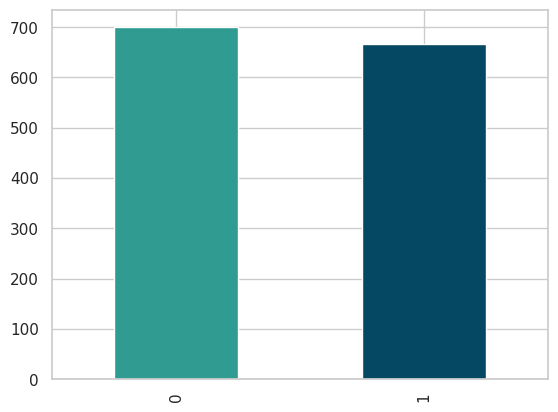

In [157]:
pd.Series(y_pred_test).value_counts().plot(kind = 'bar', color=colors)

##### **Avaliando o modelo:**

---



Para fim didático, iremos utilizar as seguintes métricas para validação do modelo:

- **`Matriz de Confusão:`** A matriz de confusão é uma representação tabular dos resultados de classificação de um modelo. Ela mostra a contagem de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos, permitindo uma análise mais detalhada do desempenho do modelo.

- **`Acurácia:`** A acurácia é uma métrica que mede a taxa de acertos do modelo, ou seja, a proporção de observações corretamente classificadas em relação ao total de observações. É uma medida geral do desempenho do modelo, indicando sua **capacidade de fazer previsões corretas**.

- **`Precision (Precisão):`** A precisão é uma métrica que mede a proporção de observações positivas corretamente identificadas em relação ao total de observações classificadas como positivas. Ela é útil para avaliar a capacidade do modelo em evitar falsos positivos, ou seja, **classificar corretamente as instâncias positivas**.

- **`Recall (Revocação):`** O recall é uma métrica que mede a proporção de observações positivas corretamente identificadas em relação ao total de observações positivas reais. Ela é útil para avaliar a capacidade do modelo em encontrar corretamente as instâncias positivas, **minimizando os falsos negativos**.

- **`Curva ROC:`** A curva ROC representa a relação entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR) em diferentes pontos de corte (limiares de decisão) do modelo. O limiar de decisão é um valor ou critério que determina em qual classe o modelo irá classificar uma instância de entrada. Geralmente, o modelo calcula uma probabilidade de pertencer a uma determinada classe e compara essa probabilidade com o limiar de decisão para fazer a classificação final. Um bom modelo de classificação geralmente apresenta uma curva ROC **próxima ao canto superior esquerdo do gráfico, indicando uma alta taxa de verdadeiros positivos (sensibilidade) e uma baixa taxa de falsos positivos**. O ponto ideal seria aquele em que o modelo alcança uma taxa de verdadeiros positivos alta, minimizando simultaneamente a taxa de falsos positivos.

- **`AUC-ROC:`** A AUC-ROC representa a probabilidade de o modelo classificar aleatoriamente um exemplo positivo mais alto do que um exemplo negativo. Quanto maior a AUC-ROC, melhor o desempenho do modelo em discriminar entre as classes. Esse valor representa a área sobre a curva ROC.

###### **Matriz de Confusão:**

---



Para interpretar a Matriz de Confusão, vamos considerar, a partir dos nosso dados:

> - Valor Positivo: Cancelado (1)
> - Valor Negativo: Não Cancelado (0)

A Matriz de Confusão trás os valores previstos comparados aos valores reais da base, assim:

> - Vedadeiro: Quando o modelo previu corretamente.
> - Falso: Quando o modelo não previu corretamente.

<img src = 'https://miro.medium.com/v2/resize:fit:1400/0*KUYgSbo0p1-5RRZW.png'/>

Dessa forma, no quadrante de Verdadeiro Positivo (VP), temos a quantidade de previsões corretas de "Cancelado" (1), enquanto no quadrante de Verdadeiro Negativo (VN), temos a quantidade de previsões corretas de "Não Cancelado" (0).

A mesma lógica se aplica aos quadrantes de Falso Positivo e Falso Negativo, representando as previsões incorretas.

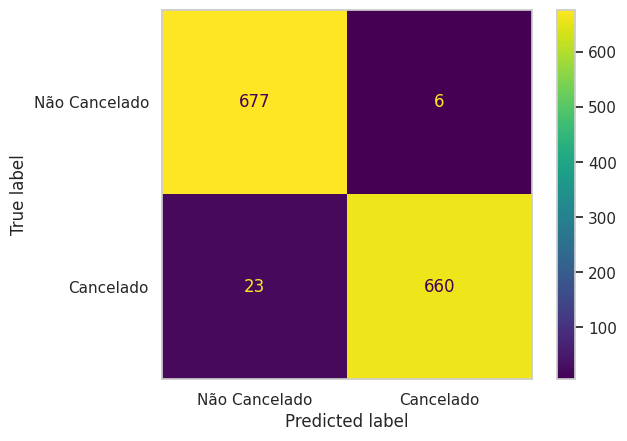

In [159]:
# matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = ["Não Cancelado", "Cancelado"]
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_res_test, y_pred_test), display_labels=class_labels).plot()
plt.grid(False)
plt.show()

Ao analisar a matriz de confusão acima, podemos observar que o modelo realizou 23 previsões incorretas de Falso Positivo, ou seja, classificou erroneamente 23 casos como "Cancelado" quando na verdade eram "Não Cancelado".

Além disso, ocorreram 6 previsões incorretas de Falso Negativo, em que o modelo categorizou erroneamente 6 casos como "Não Cancelado" quando na verdade eram "Cancelado".

###### **Acurácia e Precissão:**


---



In [160]:
# cáculo precision, recall, f1 e acurácia
from sklearn.metrics import classification_report

report = classification_report(y_res_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       683
           1       0.99      0.97      0.98       683

    accuracy                           0.98      1366
   macro avg       0.98      0.98      0.98      1366
weighted avg       0.98      0.98      0.98      1366



###### **Curva ROC e AUC-ROC:**

---



In [161]:
# cálculo da área da cuva ROC
y_pred_proba_train = pipeline.predict_proba(X_res)[:, 1]  # probabilidades da classe positiva para o conjunto de treinamento
y_pred_proba_test = pipeline.predict_proba(X_res_test)[:, 1]  # probabilidades da classe positiva para o conjunto de teste

y_train_score = roc_auc_score(y_res, y_pred_proba_train)
y_test_score = roc_auc_score(y_res_test, y_pred_proba_test)

print(y_train_score, y_test_score)

0.9994089480063635 0.9985551642160908


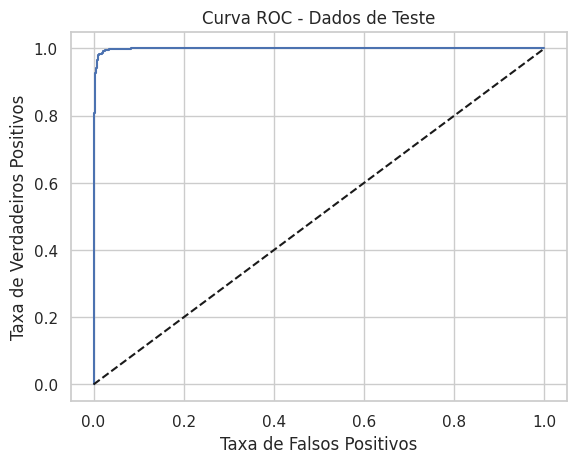

In [162]:
# plotando curva ROC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_res_test, y_pred_proba_test)

sns.set()
sns.set_style("whitegrid")

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal para referência
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Dados de Teste')
plt.show()

***Conclusões:***

Com base nos resultados da métrica de classificação (precision, recall) e da acurácia apresentados acima, podemos concluir que o modelo possui um desempenho excelente na tarefa de classificação das observações em duas classes: 0 e 1.

- A precisão média para ambas as classes é de 0.98, o que indica que o modelo tem uma alta taxa de acerto na classificação correta das observações positiva da base. **Ou seja, de tudo que o modelo classificou como "Cancelado", ele acertou 98%.**

- O recall médio de 0.98 indica que o modelo é capaz de identificar corretamente a grande maioria das observações positivas em relação ao total de observações positivas presentes na base de dados. **Ou seja, o modelo consegue detectar cerca de 98% dos casos que realmente são "Cancelados".**

- A acurácia geral do modelo é de 0.98, o que indica uma taxa de acerto elevada na classificação de todas as observações. Isso demonstra que **o modelo é capaz de realizar previsões corretas na maioria dos casos.**

- Com base nos valores de AUC-ROC fornecidos, observamos que tanto no conjunto de treinamento quanto no conjunto de teste, o modelo apresenta um desempenho extremamente bom na tarefa de classificação. A AUC-ROC próxima de 1 indica que o modelo é capaz de fazer uma distinção clara entre as classes de cancelamento e não cancelamento de vendas, **com uma taxa muito baixa de falsos positivos em relação aos verdadeiros positivos**.